In [1]:
%pylab inline
import sqlite3,copy,gc,os,random
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import multiprocessing as mp
import time
import scipy,collections

matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

In [3]:
def detectedHDFTable(HDFfile_path):
    #'share.h5'
    with pd.HDFStore(HDFfile_path) as share:
        return share.keys()

def GroupChunk(df,chunk,sorted_values):
    df=df.sort_values(by=sorted_values)
    rows =df.shape[0]
    #group=collections.OrderedDict()
    group=[]
   
    chunk_size =rows/chunk
    #print 'chunk: %d and chunk size: %d '%(chunk,chunk_size)
    #print 'length : %d'%rows
    for i in xrange(chunk):
        if i+1<chunk:
            #print (i*chunk_size,(i+1)*chunk_size)
            locals()['Group_%d'%i]=df.iloc[i*chunk_size:(i+1)*chunk_size]
        else:
            #print (i*chunk_size,-1)
            locals()['Group_%d'%i]=df.iloc[i*chunk_size:,]
        locals()['Group_%d'%i]['Group']=i
        group.append(locals()['Group_%d'%i])
        
       
        #group.update({'Group_%d'%i:locals()['Group_%d'%i]})
    
    return pd.concat(group)
def CalculateSharpeRatio(df,col_name):
    SPRtio =dict([(n,mean(df[n] - df['TBill1Mo'])/df[n].std()) for n in col_name])
    return pd.Series(SPRtio)
def CalculateSuccessRatio(GS):
    return [float(df['MAP_10_dummy'].sum())/df.shape[0] for date,df in GS.groupby('date')]
    
def Description(BG_conn,GS_conn,otherfactor,col_name,target,rt,SPRtio='SPRtio'):
    GS={}
    BG={}
    for r in rt:
        locals()['BG'+target+r ]=pd.read_sql_query('select * from %s'%(target+r),BG_conn)
        locals()['BG'+target+r ]['HighMinusLow']=locals()['BG'+target+r ]['Group_9']-locals()['BG'+target+r ]['Group_0']
        locals()['GS'+target+r ]=pd.read_sql_query('select * from %s'%(target+r),GS_conn)
        locals()['GS'+target+r ]['HighMinusLow']=locals()['GS'+target+r ]['Group_9']-locals()['GS'+target+r ]['Group_0']


        locals()['BG'+target+r ] = pd.merge(locals()['BG'+target+r ],otherfactor,on='date')
        locals()['GS'+target+r ] = pd.merge(locals()['GS'+target+r ],otherfactor,on='date')
        if SPRtio == 'SPRtio':
            GS_SPRtio=CalculateSharpeRatio(locals()['GS'+target+r ],col_name)
            BG_SPRtio=CalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        elif SPRtio =='Success':
            GS_SPRtio ='s'
            BG_SPRtio ='b'
            
        else:
            GS_SPRtio=CalculateSharpeRatio(locals()['GS'+target+r ],col_name)
            BG_SPRtio=CalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        #print locals()['BG'+target+r ]
       
        GS[r] = pd.concat([locals()['GS'+target+r ][col_name].mean(), locals()['GS'+target+r ][col_name].std(),locals()['GS'+target+r ][col_name].skew(),GS_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        GS[r]['T-value'] =scipy.stats.ttest_1samp(locals()['GS'+target+r ][col_name],0)[0]
        GS[r]['p-value of t'] =scipy.stats.ttest_1samp(locals()['GS'+target+r ][col_name],0)[1]
        BG[r] = pd.concat([locals()['BG'+target+r ][col_name].mean(), locals()['BG'+target+r ][col_name].std(),locals()['BG'+target+r ][col_name].skew(),BG_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        BG[r]['T-value'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[0]
        BG[r]['p-value of t'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[1]    
        #title ='the BoxPlot of %s Grouped by  Googel Search(%s)'%(target,r))
        GS['df_%s'%r]=locals()['GS'+target+r ][col_name+['date']]
        BG['df_%s'%r]=locals()['BG'+target+r ][col_name+['date']]
        #locals()['GB'+target+r ][col_name].plot.box(title ='the BoxPlot of %s Grouped by Bloomberg News Heat(%s)'%(target,r)))


        #GSMA_10_ewrt[col_name].mean()
        #GSMA_10_ewrt[col_name].std()
        #GSMA_10_ewrt[col_name].skew()

    #pivottableGS =pd.pivot_table(GS_ewrt,index=['GoogleSearch_level_round'],values=['MAP','MARE30','PRC','Return'],aggfunc=[np.sum,np.mean,np.std],margins=True)  
    #print GSMAP_10_ewrt.mean(),GSMAP_10_ewrt.std(),GSMAP_10_ewrt.skew()
    return BG,GS
def DescriptionMA(BG_conn,GS_conn,otherfactor,col_name,target,rt,SPRtio='SPRtio'):
    GS={}
    BG={}
    for r in rt:
        locals()['BG'+target+r ]=pd.read_sql_query('select * from %s'%(target+r),BG_conn)
        locals()['BG'+target+r ]['HighMinusLow']=locals()['BG'+target+r ]['Group_9']-locals()['BG'+target+r ]['Group_0']
        locals()['GS'+target+r ]=pd.read_sql_query('select * from %s'%(target+r),GS_conn)
        locals()['GS'+target+r ]['HighMinusLow']=locals()['GS'+target+r ]['Group_9']-locals()['GS'+target+r ]['Group_0']
        #locals()['BG'+target+r ]=RETdf(locals()['BG'+target+r ])
        #locals()['GS'+target+r ]=RETdf(locals()['GS'+target+r ])
        locals()['GS'+target+r ].dropna(inplace=True)
        locals()['BG'+target+r ].dropna(inplace=True)
        


        locals()['BG'+target+r ] = pd.merge(locals()['BG'+target+r ],otherfactor,on='date')
        locals()['GS'+target+r ] = pd.merge(locals()['GS'+target+r ],otherfactor,on='date')
        if SPRtio == 'SPRtio':
            GS_SPRtio=CalculateSharpeRatio(locals()['GS'+target+r ],col_name)
            BG_SPRtio=CalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        elif SPRtio =='Success':
            GS_SPRtio ='s'
            BG_SPRtio ='b'
            
        else:
            GS_SPRtio=CalculateSharpeRatio(locals()['GS'+target+r ],col_name)
            BG_SPRtio=CalculateSharpeRatioCalculateSharpeRatio(locals()['BG'+target+r ],col_name)
        #print locals()['BG'+target+r ]
       
        GS[r] = pd.concat([locals()['GS'+target+r ][col_name].mean(), locals()['GS'+target+r ][col_name].std(),locals()['GS'+target+r ][col_name].skew(),GS_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        GS[r]['T-value'] =scipy.stats.ttest_1samp(locals()['GS'+target+r ][col_name],0)[0]
        GS[r]['p-value of t'] =scipy.stats.ttest_1samp(locals()['GS'+target+r ][col_name],0)[1]
        BG[r] = pd.concat([locals()['BG'+target+r ][col_name].mean(), locals()['BG'+target+r ][col_name].std(),locals()['BG'+target+r ][col_name].skew(),BG_SPRtio], axis=1,keys =['Mean','Std','Skew','SRatio'])
        BG[r]['T-value'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[0]
        BG[r]['p-value of t'] =scipy.stats.ttest_1samp(locals()['BG'+target+r ][col_name],0)[1]    
        #title ='the BoxPlot of %s Grouped by  Googel Search(%s)'%(target,r))
        GS['df_%s'%r]=locals()['GS'+target+r ][col_name+['date']]
        BG['df_%s'%r]=locals()['BG'+target+r ][col_name+['date']]
        #locals()['GB'+target+r ][col_name].plot.box(title ='the BoxPlot of %s Grouped by Bloomberg News Heat(%s)'%(target,r)))


        #GSMA_10_ewrt[col_name].mean()
        #GSMA_10_ewrt[col_name].std()
        #GSMA_10_ewrt[col_name].skew()

    #pivottableGS =pd.pivot_table(GS_ewrt,index=['GoogleSearch_level_round'],values=['MAP','MARE30','PRC','Return'],aggfunc=[np.sum,np.mean,np.std],margins=True)  
    #print GSMAP_10_ewrt.mean(),GSMAP_10_ewrt.std(),GSMAP_10_ewrt.skew()
    return BG,GS
def RETdf(df):
    for col in df.columns:
        if col != 'date':
            df[col]=df[col].diff()
    return df

def cal(bgvwrtPRC):
    dfcolumn =[(u'Group0','PRC'), (u'Group1','PRC'), (u'Group2','PRC'), (u'Group3','PRC'), (u'Group4','PRC'),(u'Group5','PRC'), (u'Group6','PRC'), (u'Group7','PRC'), (u'Group8','PRC'), (u'Group9','PRC')]
    if (u'Group0','PRC') not in bgvwrtPRC.columns:
        bgvwrtPRC.columns=pd.MultiIndex.from_tuples(zip(bgvwrtPRC.columns,['PRC']*bgvwrtPRC.shape[1]),names=['Group', 'Variable'])
    else:
        pass


    ma_list = [5,10, 20,30,50, 60,100,200]
    if ('TBill1Mo','PRC') not in bgvwrtPRC.columns:
        bgvwrtPRC =bgvwrtPRC.join(otherfactor)
    else:
        pass
    for col in dfcolumn:
        bgvwrtPRC[(col[0],'RETrate')] = (bgvwrtPRC[col].diff()/bgvwrtPRC[col].shift(1))
        for ma in ma_list:
            bgvwrtPRC[(col[0],'MA_' + str(ma))] = bgvwrtPRC[col].rolling(window=ma,center=False).mean()
            temp = bgvwrtPRC[col] -bgvwrtPRC[col[0],'MA_'+str(ma)]
            bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)]=[1 if r>0 else 0 for r in temp]
        #GS[group[0],'MA%stiming'%ma] =GS[group[0],'RETrate'].shift(1)*GS[group[0],'buysignalforMA%s'%ma]+GS['TBill1Mo','PRC'].shift(1)*(1-GS[group[0],'buysignalforMA%s'%ma])
            bgvwrtPRC[col[0],'MA%stiming'%str(ma)] =bgvwrtPRC[col[0],'RETrate']*bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)]+bgvwrtPRC['TBill1Mo','PRC']*(1-bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)])
            bgvwrtPRC[col[0],'MAP%s'%str(ma)] =bgvwrtPRC[col[0],'MA%stiming'%str(ma)]-bgvwrtPRC[col[0],'RETrate']
            bgvwrtPRC[col[0],'MAP%s_dummy'%str(ma)] =[1 if n>0 else 0 for n in bgvwrtPRC[col[0],'MAP%s'%str(ma)]]
    return bgvwrtPRC

In [4]:
#share_with_gs=pd.read_csv('share_with_gs.csv')
share_with_openprice=pd.read_csv('/Users/sn0wfree/Documents/python_projects/data_collection/API/Share/wrds/sharewithopenprice.csv')
share =pd.read_hdf('share.h5','share')
#share_with_BGgroup=pd.read_hdf('share.h5','share_with_BGgroup')
#share_with_gsGroup=pd.read_hdf('share.h5','share_with_gsGroup')
share_with_openprice=share_with_openprice.dropna()
share_with_openprice =share_with_openprice[[ u'date', u'TICKER', u'PRC', u'RET', u'SHROUT', u'OPENPRC']]
share_with_openprice.PRC =abs(share_with_openprice.PRC)
share_with_openprice.SHROUT =abs(share_with_openprice.SHROUT)
share_with_openprice.OPENPRC =abs(share_with_openprice.OPENPRC)
share_with_openprice.TICKER=share_with_openprice.TICKER.astype('category')
share_with_openprice.SHROUT=share_with_openprice.SHROUT.astype(np.int64)
share_with_openprice['date']=pd.to_datetime(share_with_openprice['date'],format='%Y%m%d')
#share_with_openprice =share_with_openprice.set_index('date')
share_with_openprice['OpenMarketValue'] =share_with_openprice['OPENPRC']*share_with_openprice['SHROUT']
share_with_openprice['MarketValue'] =share_with_openprice['PRC']*share_with_openprice['SHROUT']

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
detectedHDFTable('database/allinfo.h5')
regroup =pd.read_hdf('database/allinfo.h5','allinfo')
allf =regroup[['date','TICKER','NEWS_HEAT_READ_DAVG','GoogleSearchGroup']]
allf['date']=pd.to_datetime(allf['date'],format='%Y%m%d')
allf=allf[allf.NEWS_HEAT_READ_DAVG!=183]
af =pd.merge(share_with_openprice,allf,on=['date','TICKER'])
bgaf =af[[u'date',u'TICKER',u'PRC', u'RET',u'SHROUT',u'OPENPRC',u'MarketValue',u'OpenMarketValue', u'NEWS_HEAT_READ_DAVG']].dropna()
unwanteddate =bgaf.date.value_counts()[bgaf.date.value_counts()<50].to_dict().keys()
ixs=[]
for unwanted in unwanteddate:
    ixs.extend(list(bgaf[bgaf.date==unwanted].index))
share_with_openprice_bg_clean =bgaf.drop(ixs)


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
list(share_with_openprice_bg_clean.date)[0]
share_with_openprice_bg_clean=share_with_openprice_bg_clean.set_index('date')

In [7]:
def multiprocessgroupup(ticker_dfgroupby):
    ticker,ticker_df =ticker_dfgroupby
    ticker_df['averageBloombergindex']=ticker_df['NEWS_HEAT_READ_DAVG'].mean()
    ticker_df =ticker_df.reset_index()
    return ticker_df
pool =mp.Pool()
alftbyyear=[]
for year ,year_df in share_with_openprice_bg_clean.groupby(lambda x:x.year):
    alftbyyear.extend(pool.map(multiprocessgroupup,year_df.groupby('TICKER'))) 
pool.close()
pool.join()
ted =pd.concat(alftbyyear).drop_duplicates()
ted.date=ted.date.dt.strftime('%Y%m%d')

    
   

In [8]:
def run_function(groupby):
    date ,date_df =groupby
    return GroupChunk(date_df,10,'averageBloombergindex')
#tempbggroupup = pd.concat([GroupChunk(date_df,10,'averageBloombergindex') for date ,date_df in ted.groupby('date')])
pool =mp.Pool()
tempbggroupup =pool.map(run_function,ted.groupby('date'))

pool.close()
pool.join()


/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [9]:
#tempbggroupup['MarketValue'] =tempbggroupup['OpenMarketValue']/tempbggroupup['OPENPRC']
#share_with_openprice
wd =pd.concat(tempbggroupup)

In [10]:
wd

,date,TICKER,PRC,RET,SHROUT,OPENPRC,MarketValue,OpenMarketValue,NEWS_HEAT_READ_DAVG,averageBloombergindex,Group
0,20100216,PRAA,53.25000,0.013513,15520,52.10000,8.264400e+05,8.085920e+05,0.0,0.000000,0
0,20100216,AAN,24.65000,0.016495,7757,24.60000,1.912100e+05,1.908222e+05,0.0,0.000000,0
16,20100216,AAN,30.48000,0.008604,46479,30.58000,1.416680e+06,1.421328e+06,0.0,0.000000,0
0,20100216,GE,16.04000,0.031511,10647495,15.70000,1.707858e+08,1.671657e+08,0.0,0.000000,0
16,20100216,WSO,53.77000,0.027714,27890,52.77000,1.499645e+06,1.471755e+06,0.0,0.000000,0
0,20100216,MASI,28.23000,0.020607,57979,27.77000,1.636747e+06,1.610077e+06,0.0,0.000000,0
0,20100216,WSO,53.75000,0.037244,4164,53.00000,2.238150e+05,2.206920e+05,0.0,0.000000,1
0,20100216,LZB,11.64000,0.066911,51546,11.03000,5.999954e+05,5.685524e+05,0.0,0.000000,1
0,20100216,KAR,13.93000,-0.056872,131854,14.83000,1.836726e+06,1.955395e+06,0.0,0.000000,1
0,20100216,EEFT,19.34000,0.005198,50860,19.34000,9.836324e+05,9.836324e+05,0.0,0.000000,1


In [11]:
bgsplitgroup={}
for group,group_df in wd.groupby('Group'):
    result={}
    
    for date,date_df in group_df.groupby('date'):
        OpenMarketValue =date_df.OpenMarketValue.sum()
        SHROUT =date_df.SHROUT.sum()
        MarketValue=date_df.MarketValue.sum()
        PRC_ewrt=date_df.PRC.mean()
        OPENPRC_ewrt=date_df.OPENPRC.mean()
        RET_ewrt =(PRC_ewrt-OPENPRC_ewrt)/OPENPRC_ewrt
        PRC_vwrt=MarketValue/SHROUT
        OPENPRC_vwrt=OpenMarketValue/SHROUT
        RET_vwrt =(PRC_vwrt-OPENPRC_vwrt)/OPENPRC_vwrt
        #ewrt.update({date:(group,date,PRC_ewrt,OPENPRC_ewrt,RET_ewrt,MarketValue,SHROUT,OpenMarketValue)})
        result.update({date:(group,date,PRC_ewrt,OPENPRC_ewrt,RET_ewrt,PRC_vwrt,OPENPRC_vwrt,RET_vwrt,MarketValue,SHROUT,OpenMarketValue)})
    bgsplitgroup[group] =pd.DataFrame(result,index =['group','date','PRC_ewrt','OPENPRC_ewrt','RET_ewrt','PRC_vwrt','OPENPRC_vwrt','RET_vwrt','MarketValue','SHROUT','OpenMarketValue']).T
    


        
       
       
        

In [90]:


bgvwrtgroupup=pd.concat([ewrttemp(key,value,'vwrt') for key,value in bgsplitgroup.items()],axis=1)
gsvwrtgroupup=pd.concat([ewrttemp(key,value,'vwrt') for key,value in gssplitgroup.items()],axis=1)
bgvwrtgroupup.columns =pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in bgvwrtgroupup.columns],names=['Group', 'Variable'])
gsvwrtgroupup.columns =pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in gsvwrtgroupup.columns],names=['Group', 'Variable'])



bgvwrtgroupup.index=pd.to_datetime(bgvwrtgroupup.index,format ='%Y%m%d')
gsvwrtgroupup.index=pd.to_datetime(gsvwrtgroupup.index,format ='%Y%m%d')


bgvwrtgroupup =bgvwrtgroupup.join(otherfactor)
gsvwrtgroupup =gsvwrtgroupup.join(otherfactor)
bgvwrtoutput=MAcal(bgvwrtgroupup)
gsvwrtoutput=MAcal(gsvwrtgroupup)

bgvwrtoutput.to_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','bgvwrt',complevel=9, complib='blosc')
gsvwrtoutput.to_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','gsvwrt',complevel=9, complib='blosc')




In [91]:
detectedHDFTable('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5')

['/bgewrt', '/bgvwrt', '/gsewrt', '/gsvwrt']

In [89]:
def ewrttemp(key,value,sym='ewrt'):
    ewrt_temp =value[['PRC_%s'%sym,'RET_%s'%sym]]
    ewrt_temp.columns = ['Group%d_PRC'%key,'Group%d_RET'%key]
    return ewrt_temp
    
bggroupup=pd.concat([ewrttemp(key,value) for key,value in bgsplitgroup.items()],axis=1)
bggroupup.columns =pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in bggroupup.columns],names=['Group', 'Variable'])
otherfactor =pd.read_hdf('PriceAdjustedGroup.h5','GSwithfactor')[['TBill1Mo','MktRF','SMB','HML']]
otherfactor.columns =pd.MultiIndex.from_tuples(zip(otherfactor.columns,['PRC']*otherfactor.shape[1]),names=['Group', 'Variable'])

    
bggroupup.index=pd.to_datetime(bggroupup.index,format ='%Y%m%d')
bggroupup =bggroupup.join(otherfactor)

In [226]:
def MAcal(bgvwrtPRC):
    ma_list = [5,10, 20,30,50, 60,100,200]
    if ('HighMinusLow','PRC') in bgvwrtPRC.columns or ('HighMinusLow','RET') in bgvwrtPRC.columns:
        dfcolumn =[(u'HighMinusLow','PRC'),(u'Group0','PRC'), (u'Group1','PRC'), (u'Group2','PRC'), (u'Group3','PRC'), (u'Group4','PRC'),(u'Group5','PRC'), (u'Group6','PRC'), (u'Group7','PRC'), (u'Group8','PRC'), (u'Group9','PRC')]


    else:
        dfcolumn =[(u'Group0','PRC'), (u'Group1','PRC'), (u'Group2','PRC'), (u'Group3','PRC'), (u'Group4','PRC'),(u'Group5','PRC'), (u'Group6','PRC'), (u'Group7','PRC'), (u'Group8','PRC'), (u'Group9','PRC')]
    for col in dfcolumn:
        for ma in ma_list:
            bgvwrtPRC[(col[0],'MA_' + str(ma))] = bgvwrtPRC[col].rolling(window=ma,center=False).mean()
            temp = bgvwrtPRC[col] -bgvwrtPRC[col[0],'MA_'+str(ma)]
            bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)]=[1 if r>0 else 0 for r in temp]
        #GS[group[0],'MA%stiming'%ma] =GS[group[0],'RETrate'].shift(1)*GS[group[0],'buysignalforMA%s'%ma]+GS['TBill1Mo','PRC'].shift(1)*(1-GS[group[0],'buysignalforMA%s'%ma])
            bgvwrtPRC[col[0],'MA%stiming'%str(ma)] =bgvwrtPRC[col[0],'RET']*bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)]+bgvwrtPRC['TBill1Mo','PRC']*(1-bgvwrtPRC[col[0],'buysignalforMA%s'%str(ma)])
            bgvwrtPRC[col[0],'MAP%s'%str(ma)] =bgvwrtPRC[col[0],'MA%stiming'%str(ma)]-bgvwrtPRC[col[0],'RET']
            bgvwrtPRC[col[0],'MAP%s_dummy'%str(ma)] =[1 if n>=0 else 0 for n in bgvwrtPRC[col[0],'MAP%s'%str(ma)]]
            bgvwrtPRC[col[0],'MAP%s_successrate'%str(ma)] =float(gsewrtoutput[(col[0],'MAP%s_dummy'%str(ma))].sum())/gsewrtoutput[(col[0],'MAP%s_dummy'%str(ma))].count()
    return bgvwrtPRC
bgewrtoutput=MAcal(bggroupup)

In [41]:
bgewrtoutput.to_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','bgewrt',complevel=9, complib='blosc')

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:262: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0_level0] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:262: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items_level0] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:262: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items_level0] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/Users/sn0wfree/anaconda/lib/python2.7/site-pac

In [57]:
bgewrtoutput

Group        Group0                Group1                Group2               \
Variable        PRC          RET      PRC          RET      PRC          RET   
2010-02-16  34.4033    0.0142492  40.4867   0.00239333  42.5217  -0.00109628   
2010-02-17  23.6595   0.00507647  25.7797   0.00751988  25.3183    0.0073073   
2010-02-18  20.2622    0.0128045  25.2344   0.00823728   23.003   0.00901083   
2010-02-19  18.5826   0.00151206  25.9735   0.00758913  23.2381   0.00890025   
2010-02-22  19.3708    0.0016528  26.4104   0.00540233   27.161 -0.000705172   
2010-02-23  20.4266    -0.007756  28.2803  -0.00519285  25.4256  -0.00615218   
2010-02-24  19.5357   0.00598968  28.5834   0.00523828  23.8278   0.00462895   
2010-02-25  20.2116    0.0132346   26.931     0.010256  24.6295     0.014072   
2010-02-26  18.8543  -0.00541094  29.6747  -0.00189886  22.2608  -0.00171831   
2010-03-01  20.3966    0.0149923  28.6275    0.0108799  22.6633    0.0186769   
2010-03-02   19.501   0.00632001  27.6376   0.00364143  22.4089    0.0063849   
2010-03-03  19.1662  -0.00190701   25.448  -0.00138772  21.4733  -0.00176398   
2010-03-04  19.7042   8.3836e-05  27.8938   0.00123388  22.6201  0.000857234   
2010-03-05  21.1868    0.0163703  27.2937    0.0101681  21.5429   0.00994406   
2010-03-08  23.6763   0.00125684   27.581    0.0059858  22.5441   0.00536307   
2010-03-09  24.5771   0.00709992  26.6322   0.00522778  20.7791   0.00587452   
2010-03-10  24.2758   0.00629605  24.0916   0.00635356   22.137   0.00592488   
2010-03-11  24.2849   0.00686895  23.2135   0.00670569  20.7004    0.0075298   
2010-03-12  22.6966  -0.00101052  27.5388  -0.00171367  21.2497  -0.00188683   
2010-03-15   22.303   0.00191277  27.8143   0.00105128  20.8702   0.00118576   
2010-03-16  22.5943    0.0052584  27.9663   0.00382035   21.062   0.00533505   
2010-03-17  22.7899   0.00336662  24.2537   0.00856091  22.8954   0.00483618   
2010-03-18  22.6375  -0.00291557  28.3382  -0.00478638   20.372  2.05531e-05   
2010-03-19  23.4532   -0.0137244  26.5589   -0.0105646  22.7145   -0.0125564   
2010-03-22  22.1905    0.0151372   27.861    0.0150485  20.6556    0.0136828   
2010-03-23  22.8018   0.00705334  28.3317    0.0074192  21.6791   0.00973451   
2010-03-24  24.6175  -0.00593211  26.8594  -0.00915519  20.7191  -0.00670189   
2010-03-25  25.0325   -0.0105003  26.1889   -0.0110114  20.1248  -0.00996972   
2010-03-26   24.986  -0.00467355  26.0965  -0.00310755  21.6042  -0.00428336   
2010-03-29  23.2572  0.000310984  27.7466   0.00327948  20.4974  4.46285e-05   
...             ...          ...      ...          ...      ...          ...   
2016-11-17  37.0195    0.0063866  40.0422   0.00343059  40.4699   0.00620143   
2016-11-18  37.5557  -0.00144068   39.717 -0.000678096  38.8856  -0.00173331   
2016-11-21  42.3523   0.00165213  35.1669   -0.0013035   41.099   0.00159284   
2016-11-22   39.173   0.00390584  37.0683   0.00224097  41.4619  -0.00200293   
2016-11-23  37.1427   0.00895903  44.5711    0.0133093  44.6383   0.00947741   
2016-11-25  35.2745   0.00146035  45.0087   0.00286898  43.1488   0.00316022   
2016-11-28  36.9042   -0.0100263  39.5161  -0.00850503  39.0709  -0.00943101   
2016-11-29  42.1533  -0.00286175  35.6022  0.000457153  41.3448 -9.63858e-05   
2016-11-30  38.2181   -0.0121836  34.9014   -0.0156047  40.7937   -0.0116817   
2016-12-01  39.9785   -0.0120074  34.7538   -0.0107913  40.6139  -0.00810018   
2016-12-02  35.2979   0.00276233  41.0043   0.00284751  38.5156   0.00249966   
2016-12-05  38.6862   0.00681338  38.6494   0.00734123  39.6435   0.00747803   
2016-12-06  33.8507   0.00710802  44.9537   0.00711061  42.7095   0.00669976   
2016-12-07  39.3616    0.0106445  37.7171    0.0109255  41.0481   0.00858654   
2016-12-08  36.8891   0.00986417  42.9505    0.0132062  41.4117    0.0100746   
2016-12-09  34.8251  -0.00249471   39.418   -0.0025852  43.8599  -0.00235574   
2016-12-12  43.4773  -0.00564919  35.1726   -0.0078172  40.6285  -0.00420464   


In [32]:
bgewrtoutput[('Group9','RET')][bgewrtoutput[('Group9','RET')]>0.028]
#.xs(('RET'),level='Variable', axis=1,drop_level=False)

2010-05-21    0.0419074
2010-05-25    0.0303442
2010-07-07      0.03314
2010-07-20    0.0334802
2011-08-09    0.0339036
2011-08-11    0.0378263
2015-10-02    0.0328806
Name: (Group9, RET), dtype: object

In [34]:
print bggroupup.xs(('RET'),level='Variable', axis=1,drop_level=False).mean()

Group   Variable
Group0  RET         0.000466
Group1  RET         0.000453
Group2  RET         0.000357
Group3  RET         0.000385
Group4  RET         0.000368
Group5  RET         0.000407
Group6  RET         0.000277
Group7  RET         0.000305
Group8  RET         0.000212
Group9  RET         0.000125
dtype: float64


In [44]:
regroup

,date,TICKER,NEWS_HEAT_READ_DAVG,PRC,RET,VOL,MarketValue,TBill1MoDaily,GoogleSearchGroup
0,20040115,A,NaN,32.91,0.023958,4491400.0,1.478120e+08,2.246575e-05,9.0
1,20040116,A,NaN,34.25,0.040717,4234900.0,1.450453e+08,2.191781e-05,9.0
2,20040120,A,NaN,34.01,-0.007007,3709300.0,1.261533e+08,2.191781e-05,9.0
3,20040121,A,NaN,34.77,0.022346,4373800.0,1.520770e+08,2.246575e-05,9.0
4,20040122,A,NaN,33.98,-0.022721,3581400.0,1.216960e+08,2.027397e-05,9.0
5,20040123,A,NaN,33.44,-0.015892,2155400.0,7.207658e+07,2.164384e-05,9.0
6,20040126,A,NaN,33.91,0.014055,3581800.0,1.214588e+08,2.246575e-05,9.0
7,20040127,A,NaN,36.10,0.064583,21900200.0,7.905972e+08,2.438356e-05,9.0
8,20040128,A,NaN,35.95,-0.004155,5501300.0,1.977717e+08,2.438356e-05,9.0
9,20040129,A,NaN,35.65,-0.008345,3919800.0,1.397409e+08,2.383562e-05,9.0


In [99]:
w =share_with_openprice_gs[[u'date', u'TICKER', u'PRC', u'RET', u'SHROUT', u'OPENPRC',
       u'MarketValue', u'OpenMarketValue']]

In [139]:


share_with_openprice_bg.to_hdf('database/h5/result_redo.h5','share_with_openprice_bg',complevel=9,complib='blosc')
share_with_openprice_gs.to_hdf('database/h5/result_redo.h5','share_with_openprice_gs',complevel=9,complib='blosc')

In [45]:
share_with_openprice

,date,TICKER,PRC,RET,SHROUT,OPENPRC,OpenMarketValue,MarketValue
0,2004-01-02,AEPI,9.65000,-0.009139,8177,9.53000,7.792681e+04,7.890805e+04
1,2004-01-05,AEPI,9.97000,0.033161,8177,9.87000,8.070699e+04,8.152469e+04
2,2004-01-06,AEPI,9.95000,-0.002006,8177,9.85000,8.054345e+04,8.136115e+04
3,2004-01-07,AEPI,9.75000,-0.020100,8177,9.75000,7.972575e+04,7.972575e+04
4,2004-01-08,AEPI,10.35000,0.061538,8177,9.87000,8.070699e+04,8.463195e+04
5,2004-01-09,AEPI,10.08000,-0.026087,8177,10.19000,8.332363e+04,8.242416e+04
6,2004-01-12,AEPI,9.99000,-0.008929,8177,10.09900,8.257952e+04,8.168823e+04
7,2004-01-13,AEPI,9.83000,-0.016016,8177,9.95000,8.136115e+04,8.037991e+04
8,2004-01-14,AEPI,9.84000,0.001017,8177,9.70000,7.931690e+04,8.046168e+04
9,2004-01-15,AEPI,9.65000,-0.019309,8177,9.86000,8.062522e+04,7.890805e+04


In [49]:
gsb =regroup[['date','TICKER','GoogleSearchGroup']]

In [51]:
gsb.date =pd.to_datetime(gsb.date,format='%Y%m%d')

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [54]:
gsgroupup=pd.merge(share_with_openprice,gsb,on=['date','TICKER'])
gsgroupup.date =gsgroupup.date.dt.strftime('%Y%m%d')



In [60]:
gsgroupup

,date,TICKER,PRC,RET,SHROUT,OPENPRC,OpenMarketValue,MarketValue,GoogleSearchGroup
0,20040102,AEPI,9.65000,-0.009139,8177,9.53000,7.792681e+04,7.890805e+04,2.0
1,20040105,AEPI,9.97000,0.033161,8177,9.87000,8.070699e+04,8.152469e+04,2.0
2,20040106,AEPI,9.95000,-0.002006,8177,9.85000,8.054345e+04,8.136115e+04,2.0
3,20040107,AEPI,9.75000,-0.020100,8177,9.75000,7.972575e+04,7.972575e+04,2.0
4,20040108,AEPI,10.35000,0.061538,8177,9.87000,8.070699e+04,8.463195e+04,2.0
5,20040109,AEPI,10.08000,-0.026087,8177,10.19000,8.332363e+04,8.242416e+04,2.0
6,20040112,AEPI,9.99000,-0.008929,8177,10.09900,8.257952e+04,8.168823e+04,2.0
7,20040113,AEPI,9.83000,-0.016016,8177,9.95000,8.136115e+04,8.037991e+04,2.0
8,20040114,AEPI,9.84000,0.001017,8177,9.70000,7.931690e+04,8.046168e+04,2.0
9,20040115,AEPI,9.65000,-0.019309,8177,9.86000,8.062522e+04,7.890805e+04,2.0


In [62]:
#gsgroupup

gssplitgroup={}
for group,group_df in gsgroupup.groupby('GoogleSearchGroup'):
    result={}
    for date,date_df in group_df.groupby('date'):
        OpenMarketValue =date_df.OpenMarketValue.sum()
        SHROUT =date_df.SHROUT.sum()
        MarketValue=date_df.MarketValue.sum()
        PRC_ewrt=date_df.PRC.mean()
        OPENPRC_ewrt=date_df.OPENPRC.mean()
        RET_ewrt =(PRC_ewrt-OPENPRC_ewrt)/OPENPRC_ewrt
        PRC_vwrt=MarketValue/SHROUT
        OPENPRC_vwrt=OpenMarketValue/SHROUT
        RET_vwrt =(PRC_vwrt-OPENPRC_vwrt)/OPENPRC_vwrt
        #ewrt.update({date:(group,date,PRC_ewrt,OPENPRC_ewrt,RET_ewrt,MarketValue,SHROUT,OpenMarketValue)})
        result.update({date:(group,date,PRC_ewrt,OPENPRC_ewrt,RET_ewrt,PRC_vwrt,OPENPRC_vwrt,RET_vwrt,MarketValue,SHROUT,OpenMarketValue)})
    gssplitgroup[group] =pd.DataFrame(result,index =['group','date','PRC_ewrt','OPENPRC_ewrt','RET_ewrt','PRC_vwrt','OPENPRC_vwrt','RET_vwrt','MarketValue','SHROUT','OpenMarketValue']).T
    




In [70]:
gsgroupup=pd.concat([ewrttemp(key,value) for key,value in gssplitgroup.items()],axis=1)
gsgroupup.columns =pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in gsgroupup.columns],names=['Group', 'Variable'])
#otherfactor =pd.read_hdf('PriceAdjustedGroup.h5','GSwithfactor')[['TBill1Mo','MktRF','SMB','HML']]
#otherfactor.columns =pd.MultiIndex.from_tuples(zip(otherfactor.columns,['PRC']*otherfactor.shape[1]),names=['Group', 'Variable'])

    
gsgroupup.index=pd.to_datetime(gsgroupup.index,format ='%Y%m%d')
gsgroupup =gsgroupup.join(otherfactor)

In [75]:
gsewrtoutput=MAcal(gsgroupup)
#gsgroupup

In [84]:
gsewrtoutput.xs(('RET'),level='Variable', axis=1,drop_level=False).mean()

Group   Variable
Group0  RET         0.000522
Group1  RET         0.000387
Group2  RET         0.000321
Group3  RET         0.000343
Group4  RET         0.000310
Group5  RET         0.000326
Group6  RET         0.000293
Group7  RET         0.000202
Group8  RET         0.000161
Group9  RET         0.000338
dtype: float64

In [326]:
gsewrtoutput.to_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','gsewrt',complevel=9, complib='blosc')
bgewrtoutput.to_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','bgewrt',complevel=9, complib='blosc')

/Users/sn0wfree/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block2_values] [items->[('Group0', 'PRC'), ('Group0', 'RET'), ('Group1', 'PRC'), ('Group1', 'RET'), ('Group2', 'PRC'), ('Group2', 'RET'), ('Group3', 'PRC'), ('Group3', 'RET'), ('Group4', 'PRC'), ('Group4', 'RET'), ('Group5', 'PRC'), ('Group5', 'RET'), ('Group6', 'PRC'), ('Group6', 'RET'), ('Group7', 'PRC'), ('Group7', 'RET'), ('Group8', 'PRC'), ('Group8', 'RET'), ('Group9', 'PRC'), ('Group9', 'RET'), ('Group0', 'MA5timing'), ('Group0', 'MAP5'), ('Group0', 'MA10timing'), ('Group0', 'MAP10'), ('Group0', 'MA20timing'), ('Group0', 'MAP20'), ('Group0', 'MA30timing'), ('Group0', 'MAP30'), ('Group0', 'MA50timing'), ('Group0', 'MAP50'), ('Group0', 'MA60timing'), ('Group0', 'MAP60'), ('Group0', 'MA100timing'), ('Group0', 'MAP100'), ('Group0', 'MA200timing'), ('G

In [227]:
gsewrtoutput[('HighMinusLow','PRC')] =gsewrtoutput[('Group9','PRC')]-gsewrtoutput[('Group0','PRC')]
gsewrtoutput[('HighMinusLow','RET')] =gsewrtoutput[('Group9','RET')]-gsewrtoutput[('Group0','RET')]
gsewrtoutput=MAcal(gsewrtoutput)
gsewrtoutput

bgewrtoutput[('HighMinusLow','PRC')] =bgewrtoutput[('Group9','PRC')]-bgewrtoutput[('Group0','PRC')]
bgewrtoutput[('HighMinusLow','RET')] =bgewrtoutput[('Group9','RET')]-bgewrtoutput[('Group0','RET')]
bgewrtoutput=MAcal(bgewrtoutput)
bgewrtoutput


Group        Group0                Group1                Group2               \
Variable        PRC          RET      PRC          RET      PRC          RET   
2010-02-16  34.4033    0.0142492  40.4867   0.00239333  42.5217  -0.00109628   
2010-02-17  23.6595   0.00507647  25.7797   0.00751988  25.3183    0.0073073   
2010-02-18  20.2622    0.0128045  25.2344   0.00823728   23.003   0.00901083   
2010-02-19  18.5826   0.00151206  25.9735   0.00758913  23.2381   0.00890025   
2010-02-22  19.3708    0.0016528  26.4104   0.00540233   27.161 -0.000705172   
2010-02-23  20.4266    -0.007756  28.2803  -0.00519285  25.4256  -0.00615218   
2010-02-24  19.5357   0.00598968  28.5834   0.00523828  23.8278   0.00462895   
2010-02-25  20.2116    0.0132346   26.931     0.010256  24.6295     0.014072   
2010-02-26  18.8543  -0.00541094  29.6747  -0.00189886  22.2608  -0.00171831   
2010-03-01  20.3966    0.0149923  28.6275    0.0108799  22.6633    0.0186769   
2010-03-02   19.501   0.00632001  27.6376   0.00364143  22.4089    0.0063849   
2010-03-03  19.1662  -0.00190701   25.448  -0.00138772  21.4733  -0.00176398   
2010-03-04  19.7042   8.3836e-05  27.8938   0.00123388  22.6201  0.000857234   
2010-03-05  21.1868    0.0163703  27.2937    0.0101681  21.5429   0.00994406   
2010-03-08  23.6763   0.00125684   27.581    0.0059858  22.5441   0.00536307   
2010-03-09  24.5771   0.00709992  26.6322   0.00522778  20.7791   0.00587452   
2010-03-10  24.2758   0.00629605  24.0916   0.00635356   22.137   0.00592488   
2010-03-11  24.2849   0.00686895  23.2135   0.00670569  20.7004    0.0075298   
2010-03-12  22.6966  -0.00101052  27.5388  -0.00171367  21.2497  -0.00188683   
2010-03-15   22.303   0.00191277  27.8143   0.00105128  20.8702   0.00118576   
2010-03-16  22.5943    0.0052584  27.9663   0.00382035   21.062   0.00533505   
2010-03-17  22.7899   0.00336662  24.2537   0.00856091  22.8954   0.00483618   
2010-03-18  22.6375  -0.00291557  28.3382  -0.00478638   20.372  2.05531e-05   
2010-03-19  23.4532   -0.0137244  26.5589   -0.0105646  22.7145   -0.0125564   
2010-03-22  22.1905    0.0151372   27.861    0.0150485  20.6556    0.0136828   
2010-03-23  22.8018   0.00705334  28.3317    0.0074192  21.6791   0.00973451   
2010-03-24  24.6175  -0.00593211  26.8594  -0.00915519  20.7191  -0.00670189   
2010-03-25  25.0325   -0.0105003  26.1889   -0.0110114  20.1248  -0.00996972   
2010-03-26   24.986  -0.00467355  26.0965  -0.00310755  21.6042  -0.00428336   
2010-03-29  23.2572  0.000310984  27.7466   0.00327948  20.4974  4.46285e-05   
...             ...          ...      ...          ...      ...          ...   
2016-11-17  37.0195    0.0063866  40.0422   0.00343059  40.4699   0.00620143   
2016-11-18  37.5557  -0.00144068   39.717 -0.000678096  38.8856  -0.00173331   
2016-11-21  42.3523   0.00165213  35.1669   -0.0013035   41.099   0.00159284   
2016-11-22   39.173   0.00390584  37.0683   0.00224097  41.4619  -0.00200293   
2016-11-23  37.1427   0.00895903  44.5711    0.0133093  44.6383   0.00947741   
2016-11-25  35.2745   0.00146035  45.0087   0.00286898  43.1488   0.00316022   
2016-11-28  36.9042   -0.0100263  39.5161  -0.00850503  39.0709  -0.00943101   
2016-11-29  42.1533  -0.00286175  35.6022  0.000457153  41.3448 -9.63858e-05   
2016-11-30  38.2181   -0.0121836  34.9014   -0.0156047  40.7937   -0.0116817   
2016-12-01  39.9785   -0.0120074  34.7538   -0.0107913  40.6139  -0.00810018   
2016-12-02  35.2979   0.00276233  41.0043   0.00284751  38.5156   0.00249966   
2016-12-05  38.6862   0.00681338  38.6494   0.00734123  39.6435   0.00747803   
2016-12-06  33.8507   0.00710802  44.9537   0.00711061  42.7095   0.00669976   
2016-12-07  39.3616    0.0106445  37.7171    0.0109255  41.0481   0.00858654   
2016-12-08  36.8891   0.00986417  42.9505    0.0132062  41.4117    0.0100746   
2016-12-09  34.8251  -0.00249471   39.418   -0.0025852  43.8599  -0.00235574   
2016-12-12  43.4773  -0.00564919  35.1726   -0.0078172  40.6285  -0.00420464   


In [206]:
gsewrtoutput.xs(('MAP10'),level='Variable', axis=1,drop_level=False)

Group,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,HighMinusLow
Variable,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10
2004-01-02,-0.000379305,-0.00245876,0.00265879,-2.07956e-05,0.00239271,0.00412736,0.00298443,0.00649162,0.00323217,0.00296118,0.00336459
2004-01-05,-0.0038003,-0.00351531,-0.00890171,-0.00861928,-0.00657019,-0.00573484,-0.00507548,-0.00451424,-0.00286376,-0.0027776,0.00104681
2004-01-06,-0.000521576,0.000407141,-0.00426583,-0.0033407,-0.000388726,-0.00286514,-0.00253788,-0.00487158,-0.00305867,-0.000960908,-0.000415222
2004-01-07,-0.00177506,-0.00539536,-0.00337439,-0.00414497,-0.00221235,-0.00466274,-0.00299046,-0.000821644,-0.00163665,-0.00279329,-0.000994117
2004-01-08,-0.00205963,-0.00258483,-0.00456717,-0.00220587,-0.00325158,1.879e-05,-0.00164315,0.000465244,-0.000125092,-0.000748872,0.0013346
2004-01-09,0.00381665,0.00233429,0.00379218,0.00265157,0.000282735,0.00114056,0.00239089,-0.00226191,-0.00202842,0.00101072,-0.00278209
2004-01-12,-0.0115075,-0.00615796,-0.0071485,-0.00569159,-0.00527273,-0.00289262,-0.00431406,-0.00411608,0.000613035,-0.00246395,0.00906762
2004-01-13,-0.00165469,-0.000619601,0.00222528,0.00228818,0.00421857,0.000947342,0.00413806,0.00282831,0.00482452,0.00335412,0.00503238
2004-01-14,-0.00312479,-0.00864786,-0.00446136,-0.0031684,-0.00415616,-0.00543068,-0.00375767,-0.00900534,-0.00739872,-0.00240673,0.000741341


In [208]:
ma_list =[5,20,50,100,200]
ma=10
variables =['RET','MA%dtiming'%ma,'MAP%d'%ma]
pd.concat([changecolumns(gsewrtoutput,variable) for variable in variables],axis=1).to_csv('gstemp.csv')
pd.concat([changecolumns(bgewrtoutput,variable) for variable in variables],axis=1).to_csv('bgtemp.csv')




               RETmean    RETstd   RETskew  RETsharperatio  statistic  \
Group0        0.000522  0.010689  0.260583        0.045773   2.780600   
Group1        0.000387  0.011667 -0.130135        0.030384   1.889469   
Group2        0.000321  0.011719 -0.030952        0.024601   1.559314   
Group3        0.000343  0.011035 -0.082319        0.028178   1.772855   
Group4        0.000310  0.010700 -0.204042        0.025941   1.650680   
Group5        0.000326  0.011049 -0.312688        0.026597   1.682590   
Group6        0.000293  0.011147 -0.246395        0.023353   1.496314   
Group7        0.000202  0.011615 -0.284858        0.014587   0.990307   
Group8        0.000161  0.011644 -0.350259        0.011032   0.787358   
Group9        0.000338  0.010626 -0.561799        0.028757   1.812298   
HighMinusLow -0.000184  0.006144 -0.527084       -0.035186  -1.703170   

                pvalue  
Group0        0.005457  
Group1        0.058918  
Group2        0.119020  
Group3        0.076347 

In [34]:
ma_list =[5,20,50,100,200]
ma=10
variables =['RET','MA%dtiming'%ma,'MAP%d'%ma]
pd.concat([changecolumns(gsewrtoutput,variable) for variable in variables],axis=1)

               RETmean    RETstd   RETskew  RETsharperatio  statistic  \
Group0        0.000522  0.010689  0.260583        0.045773   2.780600   
Group1        0.000387  0.011667 -0.130135        0.030384   1.889469   
Group2        0.000321  0.011719 -0.030952        0.024601   1.559314   
Group3        0.000343  0.011035 -0.082319        0.028178   1.772855   
Group4        0.000310  0.010700 -0.204042        0.025941   1.650680   
Group5        0.000326  0.011049 -0.312688        0.026597   1.682590   
Group6        0.000293  0.011147 -0.246395        0.023353   1.496314   
Group7        0.000202  0.011615 -0.284858        0.014587   0.990307   
Group8        0.000161  0.011644 -0.350259        0.011032   0.787358   
Group9        0.000338  0.010626 -0.561799        0.028757   1.812298   
HighMinusLow -0.000184  0.006144 -0.527084       -0.035186  -1.703170   

                pvalue  
Group0        0.005457  
Group1        0.058918  
Group2        0.119020  
Group3        0.076347 

,RETmean,RETstd,RETskew,RETsharperatio,statistic,pvalue,MA10timingmean,MA10timingstd,MA10timingskew,MA10timingsharperatio,statistic,pvalue,MAP10mean,MAP10std,MAP10skew,MAP10sharperatio,statistic,pvalue
Group0,0.000522,0.010689,0.260583,0.045773,2.780600,0.005457,0.001906,0.007289,2.038091,0.257063,14.897439,1.336349e-48,0.001385,0.007477,0.889710,0.180830,10.548454,1.334801e-25
Group1,0.000387,0.011667,-0.130135,0.030384,1.889469,0.058918,0.002095,0.007495,2.033384,0.275242,15.926031,4.838003e-55,0.001709,0.008535,1.435789,0.196364,11.402711,1.470325e-29
Group2,0.000321,0.011719,-0.030952,0.024601,1.559314,0.119020,0.002122,0.007304,1.825706,0.286032,16.547146,4.158476e-59,0.001801,0.008743,0.844184,0.202261,11.733444,3.630140e-31
Group3,0.000343,0.011035,-0.082319,0.028178,1.772855,0.076347,0.001471,0.006812,1.479027,0.211119,12.298028,5.248667e-34,0.001127,0.008493,0.685833,0.128910,7.561289,5.163835e-14
Group4,0.000310,0.010700,-0.204042,0.025941,1.650680,0.098901,0.001542,0.006753,1.715029,0.223556,13.008887,9.430841e-38,0.001232,0.008072,1.231243,0.148612,8.694934,5.416458e-18
Group5,0.000326,0.011049,-0.312688,0.026597,1.682590,0.092551,0.001506,0.006920,1.661092,0.212984,12.400062,1.563193e-34,0.001180,0.008410,1.386873,0.136436,7.992137,1.826399e-15
Group6,0.000293,0.011147,-0.246395,0.023353,1.496314,0.134669,0.001743,0.006821,1.739208,0.250766,14.556167,1.517613e-46,0.001450,0.008529,1.157059,0.166222,9.685812,6.836023e-22
Group7,0.000202,0.011615,-0.284858,0.014587,0.990307,0.322098,0.001763,0.007121,2.119693,0.242945,14.099235,7.379734e-44,0.001561,0.008876,1.481580,0.172158,10.015454,2.829511e-23
Group8,0.000161,0.011644,-0.350259,0.011032,0.787358,0.431130,0.001830,0.007169,1.953682,0.250687,14.538510,1.933624e-46,0.001669,0.008842,1.598177,0.185055,10.750938,1.631961e-26
Group9,0.000338,0.010626,-0.561799,0.028757,1.812298,0.070033,0.001459,0.006633,1.510035,0.215104,12.532372,3.206978e-35,0.001121,0.008106,1.834793,0.134319,7.879761,4.439968e-15


In [32]:
ma_list =[5,20,50,100,200]
ma=10
variables =['RET','MA%dtiming'%ma,'MAP%d'%ma]
def changecolumns(gsewrtoutput,variable):
    target =gsewrtoutput.xs((variable),level='Variable', axis=1,drop_level=False)
    if ('HighMinusLow',variable) in target.columns:
        target.columns =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']
        
    else:
        target.columns =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9']


    
    mean =pd.DataFrame(target.mean(),columns=[variable+'mean']).T
    #target_copy =copy.deepcopy(target)
    tandp =pd.DataFrame([scipy.stats.ttest_1samp(target[col],0) for col in target.columns],index=target.columns)
    #print scipy.stats.ttest_1samp(target,0)[0]
    std =pd.DataFrame(target.std(),columns=[variable+'std']).T
    skew =pd.DataFrame(target.skew(),columns=[variable+'skew']).T
    mss =pd.concat([mean,std,skew]).T 
    
    sharperatio=pd.DataFrame((mss[variable+'mean'] -3.2488675939801715e-05)/mss[variable+'std'],columns=[variable+'sharperatio'])
    #print 
    
    
    
    #sharperatio
    

    #SPRtio =dict([(n,mean(df[n] - df['TBill1Mo'])/df[n].std()) for n in col_name])


    
    print mss.join([sharperatio,tandp])
    #mean.columns=['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9']
    return mss.join([sharperatio,tandp])

pd.concat([changecolumns(gsewrtoutput,variable) for variable in variables],axis=1).to_csv('gstemp.csv')
   

    
    
    


               RETmean    RETstd   RETskew  RETsharperatio  statistic  \
Group0        0.000522  0.010689  0.260583        0.045773   2.780600   
Group1        0.000387  0.011667 -0.130135        0.030384   1.889469   
Group2        0.000321  0.011719 -0.030952        0.024601   1.559314   
Group3        0.000343  0.011035 -0.082319        0.028178   1.772855   
Group4        0.000310  0.010700 -0.204042        0.025941   1.650680   
Group5        0.000326  0.011049 -0.312688        0.026597   1.682590   
Group6        0.000293  0.011147 -0.246395        0.023353   1.496314   
Group7        0.000202  0.011615 -0.284858        0.014587   0.990307   
Group8        0.000161  0.011644 -0.350259        0.011032   0.787358   
Group9        0.000338  0.010626 -0.561799        0.028757   1.812298   
HighMinusLow -0.000184  0.006144 -0.527084       -0.035186  -1.703170   

                pvalue  
Group0        0.005457  
Group1        0.058918  
Group2        0.119020  
Group3        0.076347 

In [169]:
gsewrtoutput[('TBill1Mo','PRC')].mean()


3.2488675939801715e-05

In [186]:
target =gsewrtoutput.xs(('RET'),level='Variable', axis=1,drop_level=False)


Group,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9
Variable,RET,RET,RET,RET,RET,RET,RET,RET,RET,RET
2004-01-02,0.108325,0.882023,-0.489687,0.0115164,-0.453767,-0.649531,-0.530459,-0.808826,-0.559291,-0.527659
2004-01-05,1.64683,1.46196,8.64063,7.97634,4.34428,3.32461,2.65864,2.17295,1.0862,1.04099
2004-01-06,0.149253,-0.0930716,1.97902,1.35511,0.11099,1.08693,0.920284,2.47417,1.19219,0.285382
2004-01-07,0.581505,2.96788,1.37536,1.88899,0.767665,2.29483,1.1545,0.240576,0.52675,1.04915
2004-01-08,0.700176,0.943214,2.21564,0.764634,1.3022,0.00128746,0.529173,-0.106478,0.038704,0.217701
2004-01-09,-0.62054,-0.445588,-0.618156,-0.488779,-0.0638952,-0.247929,-0.453552,0.789972,0.686726,-0.222585
2004-01-12,17.6105,3.81423,5.18722,3.27744,2.84637,1.10157,2.01573,1.86786,-0.139481,0.884509
2004-01-13,0.533566,0.17816,-0.429965,-0.439056,-0.657669,-0.209961,-0.650538,-0.511402,-0.706885,-0.572889
2004-01-14,1.22888,8.03957,2.12999,1.25372,1.8966,3.00276,1.61778,8.89441,5.59046,0.856891


In [218]:
float(gsewrtoutput[('Group8','MAP10_dummy')].sum())/gsewrtoutput[('Group8','MAP10_dummy')].count()

0.8286594761171032

In [228]:
gsewrtoutput.xs(('MAP10_successrate'),level='Variable', axis=1,drop_level=False).T

,,2004-01-02 00:00:00,2004-01-05 00:00:00,2004-01-06 00:00:00,2004-01-07 00:00:00,2004-01-08 00:00:00,2004-01-09 00:00:00,2004-01-12 00:00:00,2004-01-13 00:00:00,2004-01-14 00:00:00,2004-01-15 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
Group,Variable,,,,,,,,,,,,,,,,,,,,,
HighMinusLow,MAP10_successrate,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,...,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277,0.780277
Group0,MAP10_successrate,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,...,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874,0.817874
Group1,MAP10_successrate,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,...,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892,0.829892
Group2,MAP10_successrate,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,...,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300,0.845300
Group3,MAP10_successrate,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,...,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918,0.796918
Group4,MAP10_successrate,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,...,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849,0.801849
Group5,MAP10_successrate,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,...,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094,0.811094
Group6,MAP10_successrate,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,...,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496,0.822496
Group7,MAP10_successrate,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,...,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723,0.819723


In [232]:
bgtest=bgewrtoutput.xs(('MAP10_dummy'),level='Variable', axis=1,drop_level=False)
bgtest.columns =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']

pd.DataFrame(bgtest.sum()/bgtest.shape[0])

In [239]:
gstest=gsewrtoutput.xs(('MAP10_dummy'),level='Variable', axis=1,drop_level=False)
gstest.columns =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']

pd.DataFrame(gstest.sum()/gstest.shape[0])

,0
Group0,0.817874
Group1,0.829892
Group2,0.845300
Group3,0.796918
Group4,0.801849
Group5,0.811094
Group6,0.822496
Group7,0.819723
Group8,0.828659
Group9,0.792912


In [241]:
gsewrtoutput.columns

MultiIndex(levels=[[u'Group0', u'Group1', u'Group2', u'Group3', u'Group4', u'Group5', u'Group6', u'Group7', u'Group8', u'Group9', u'HML', u'MktRF', u'SMB', u'TBill1Mo', u'HighMinusLow'], [u'PRC', u'RET', u'MA_5', u'buysignalforMA5', u'MA5timing', u'MAP5', u'MAP5_dummy', u'MA_10', u'buysignalforMA10', u'MA10timing', u'MAP10', u'MAP10_dummy', u'MA_20', u'buysignalforMA20', u'MA20timing', u'MAP20', u'MAP20_dummy', u'MA_30', u'buysignalforMA30', u'MA30timing', u'MAP30', u'MAP30_dummy', u'MA_50', u'buysignalforMA50', u'MA50timing', u'MAP50', u'MAP50_dummy', u'MA_60', u'buysignalforMA60', u'MA60timing', u'MAP60', u'MAP60_dummy', u'MA_100', u'buysignalforMA100', u'MA100timing', u'MAP100', u'MAP100_dummy', u'MA_200', u'buysignalforMA200', u'MA200timing', u'MAP200', u'MAP200_dummy', u'MAP5_successrate', u'MAP10_successrate', u'MAP20_successrate', u'MAP30_successrate', u'MAP50_successrate', u'MAP60_successrate', u'MAP100_successrate', u'MAP200_successrate']],
           labels=[[0, 0, 1, 1, 2, 2

In [247]:
def altlaglength(gsewrtPRC,bgewrtPRC):
    targets =['MAP5','MAP10','MAP20','MAP50','MAP100','MAP200']
    MAP=collections.OrderedDict()
    for target in targets:
        col_name =[('HighMinusLow',target),('Group0',target),('Group1',target),('Group2',target),('Group3',target),('Group4',target),('Group5',target),('Group6',target),('Group7',target),('Group8',target),('Group9',target)]


        #target ='MAP10'
        GStestFF3={}
        GStestCAPM={}
        BGtestFF3={}
        BGtestCAPM={}
        BGtestFF3_var={}
        GStestFF3_var={}
        for group in col_name:
            #locals()['BG'+target+r ] = pd.merge(GSrealMAP[1],otherfactor,on='date')
            #locals()['GS'+target+r ] = pd.merge(BGrealMAP[1],otherfactor,on='date')
            CMDFF3 =[group]+[('MktRF','PRC') ,('SMB','PRC'), ('HML','PRC')]
            CMDCAPM =[group]+[('MktRF','PRC')]

            gsff3 =gsewrtPRC[CMDFF3]
            #gscapm=gsewrtPRC[CMDCAPM]
            bgff3 =bgewrtPRC[CMDFF3]
            #bgcapm=bgewrtPRC[CMDCAPM]
            gsff3 =gsff3.dropna()
            #gscapm=gscapm.dropna()
            bgff3 =bgff3.dropna()
            #bgcapm=bgcapm.dropna()

            CMDFF3 =[group[0],'MktRF','SMB','HML']
            CMDCAPM=[group[0],'MktRF']
            gsff3.columns =CMDFF3
            #[group[0],'MktRF','SMB','HML']
            #gscapm.columns =CMDCAPM
            bgff3.columns =CMDFF3
            #bgcapm.columns =CMDCAPM
            GStestFF3[group[0]] = sm.ols(formula='~'.join(CMDFF3[0:2])+'+'+"+".join(CMDFF3[2:]), data=gsff3).fit()
            #GStestFF3_var[group[0]] =GStestFF3[group[0]]
            GStestFF3_t =pd.concat([GStestFF3[group[0]].params,GStestFF3[group[0]].tvalues],axis=1)
            GStestFF3_t.columns =['%s-%s-params'%(group[0],target),'%s-%s-tvalues'%(group[0],target)]
            GStestFF3_var[group[0]]=GStestFF3_t

            
            GStestCAPM[group[0]] = sm.ols(formula='~'.join(CMDCAPM[0:2]), data=gsff3).fit()
            BGtestFF3[group[0]] = sm.ols(formula='~'.join(CMDFF3[0:2])+'+'+"+".join(CMDFF3[2:]), data=bgff3).fit()
            BGtestFF3_t =pd.concat([BGtestFF3[group[0]].params,BGtestFF3[group[0]].tvalues],axis=1)
            BGtestFF3_t.columns =['%s-%s-params'%(group[0],target),'%s-%s-tvalues'%(group[0],target)]
            BGtestFF3_var[group[0]]=BGtestFF3_t




            BGtestFF3_var[group[0]]=GStestFF3_t
            BGtestCAPM[group[0]] = sm.ols(formula='~'.join(CMDCAPM[0:2]), data=bgff3).fit()
        MAP[target]=(GStestFF3,GStestCAPM,BGtestFF3,BGtestCAPM)
        #MAP[target]=(GStestFF3_var,GStestCAPM,BGtestFF3_var,BGtestCAPM)
    return MAP
   



Axes(0.125,0.2;0.775x0.68)


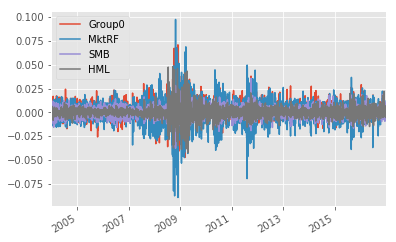

In [292]:
CMDFF3 =[('Group0','MAP10')]+[('MktRF','PRC') ,('SMB','PRC'), ('HML','PRC')]
CMDCAPM =[('Group0','MAP10')]+[('MktRF','PRC')]

gsff3 =gsewrtoutput[CMDFF3]
            
bgff3 =bgewrtoutput[CMDFF3]


CMDFF3 =['Group0','MktRF','SMB','HML']
gsff3.columns =CMDFF3
gsff3=gsff3.dropna()
print gsff3.plot()
gsff3.to_csv('gsff3group0.csv')


In [323]:
group =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']
map123 =['MAP5','MAP10','MAP20','MAP50','MAP100','MAP200']+['MA_5','MA_10','MA_20','MA_50','MA_100','MA_200']
name =[]
for g in group:
    t =[(g,m) for m in map123]
    name.extend(t)
print name

[('Group0', 'MAP5'), ('Group0', 'MAP10'), ('Group0', 'MAP20'), ('Group0', 'MAP50'), ('Group0', 'MAP100'), ('Group0', 'MAP200'), ('Group0', 'MA_5'), ('Group0', 'MA_10'), ('Group0', 'MA_20'), ('Group0', 'MA_50'), ('Group0', 'MA_100'), ('Group0', 'MA_200'), ('Group1', 'MAP5'), ('Group1', 'MAP10'), ('Group1', 'MAP20'), ('Group1', 'MAP50'), ('Group1', 'MAP100'), ('Group1', 'MAP200'), ('Group1', 'MA_5'), ('Group1', 'MA_10'), ('Group1', 'MA_20'), ('Group1', 'MA_50'), ('Group1', 'MA_100'), ('Group1', 'MA_200'), ('Group2', 'MAP5'), ('Group2', 'MAP10'), ('Group2', 'MAP20'), ('Group2', 'MAP50'), ('Group2', 'MAP100'), ('Group2', 'MAP200'), ('Group2', 'MA_5'), ('Group2', 'MA_10'), ('Group2', 'MA_20'), ('Group2', 'MA_50'), ('Group2', 'MA_100'), ('Group2', 'MA_200'), ('Group3', 'MAP5'), ('Group3', 'MAP10'), ('Group3', 'MAP20'), ('Group3', 'MAP50'), ('Group3', 'MAP100'), ('Group3', 'MAP200'), ('Group3', 'MA_5'), ('Group3', 'MA_10'), ('Group3', 'MA_20'), ('Group3', 'MA_50'), ('Group3', 'MA_100'), ('Gro

In [4]:
gsewrtoutput=pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','gsewrt')
bgewrtoutput=pd.read_hdf('/Users/sn0wfree/Documents/python_projects/data_collection/API/profit/database/lastgroupresult.h5','bgewrt')

In [15]:
group =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']
MAPMA10 =['MAP10','MA_10']
name=[]
for g in group:
    name.extend([(g,ma) for ma in MAPMA10])
        
print name   


FF3=[('MktRF','PRC') ,('SMB','PRC'), ('HML','PRC')]

gsff3col =gsewrtoutput[name+FF3].dropna()[zip(group,['MAP10']*11)+FF3]
bgff3col =bgewrtoutput[name+FF3].dropna()[zip(group,['MAP10']*11)+FF3]


[('Group0', 'MAP10'), ('Group0', 'MA_10'), ('Group1', 'MAP10'), ('Group1', 'MA_10'), ('Group2', 'MAP10'), ('Group2', 'MA_10'), ('Group3', 'MAP10'), ('Group3', 'MA_10'), ('Group4', 'MAP10'), ('Group4', 'MA_10'), ('Group5', 'MAP10'), ('Group5', 'MA_10'), ('Group6', 'MAP10'), ('Group6', 'MA_10'), ('Group7', 'MAP10'), ('Group7', 'MA_10'), ('Group8', 'MAP10'), ('Group8', 'MA_10'), ('Group9', 'MAP10'), ('Group9', 'MA_10'), ('HighMinusLow', 'MAP10'), ('HighMinusLow', 'MA_10')]


In [24]:
gsff3col.columns=[u'Group0', u'Group1', u'Group2', u'Group3', u'Group4', u'Group5', u'Group6', u'Group7', u'Group8', u'Group9',  u'HighMinusLow', u'MktRF', u'SMB', u'HML']
bgff3col.columns=[u'Group0', u'Group1', u'Group2', u'Group3', u'Group4', u'Group5', u'Group6', u'Group7', u'Group8', u'Group9',  u'HighMinusLow', u'MktRF', u'SMB', u'HML']
gsff3col.to_csv('gsff3col.csv')
bgff3col.to_csv('bgff3col.csv')

In [29]:
group =['Group0','Group1','Group2','Group3','Group4','Group5','Group6','Group7','Group8','Group9','HighMinusLow']
FF3=[('MktRF','PRC') ,('SMB','PRC'), ('HML','PRC')]
FF3name =['MktRF','SMB','HML']
malist=[5,20,50,100,200]
for ma in malist:
    locals()['MAPMA%d'%ma] =['MAP%d'%ma,'MA_%d'%ma]
    name=[]
    for g in group:
        name.extend([(g,m) for m in locals()['MAPMA%d'%ma]])
    locals()['gsff3colMAP%d'%ma] =gsewrtoutput[name+FF3].dropna()[zip(group,['MAP%d'%ma]*11)+FF3]
    locals()['bgff3colMAP%d'%ma] =bgewrtoutput[name+FF3].dropna()[zip(group,['MAP%d'%ma]*11)+FF3]
    locals()['gsff3colMAP%d'%ma].columns =group+FF3name
    locals()['bgff3colMAP%d'%ma].columns =group+FF3name
    locals()['gsff3colMAP%d'%ma].to_csv('result/gsff3colMAP%d.csv'%ma)
    locals()['bgff3colMAP%d'%ma].to_csv('result/bgff3colMAP%d.csv'%ma)

Group,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,HighMinusLow,MktRF,SMB,HML
Variable,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,MAP10,PRC,PRC,PRC
2004-01-15,-0.00161001,0,0,0,0,0,-0.00124863,0,0,0,0,0.0015,0.0004,-0.0028
2004-01-16,0,0,0,0,0,0,-0.00254254,0,0,-0.000186089,0.0032773,0.0072,0.0011,0.0056
2004-01-20,0,0,0,0,0,-0.00392949,-0.00461029,0,0,0,0,0.0015,0.0119,0.0058
2004-01-21,0,0,0,0,0,-0.0080609,0,0,-0.00572672,0,0,0.0064,-0.0112,0.0042
2004-01-22,0,0,0,0,0,0,0,0,0.00339455,0,-0.00387415,-0.0032,-0.0062,0.0006
2004-01-23,0,0,0,0,0,0,0,0,0.00147682,0.000813946,0.0062577,-0.0014,0.0091,-0.0028
2004-01-26,0,0,0,0,0,-0.00753885,0,0,-0.00416253,0,0,0.0112,-0.0010,-0.0033
2004-01-27,0,0,0,0,0,0,0,0,0.00596543,0.00639583,0.000746794,-0.0096,-0.0005,0.0003
2004-01-28,0.0168664,0.0190726,0.0153282,0.0170232,0.017183,0.0181621,0.0164867,0.0199545,0.0193647,0.0148303,-0.00201175,-0.0144,-0.0034,-0.0044
